In [9]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 9.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for peewee: filename=peewee-3.18.1-cp312-cp312-macosx_11_0_arm64.whl size=264309 sha256=2d7abad1c970b247ca8a37627e66ad95f120f10f78f0d10c600de66331135581
  Stored in directory: /Users/vithushanesan/Library/Caches/pip/wheels/1a/57/6a/bb71346381d0d911cd4ce3026f1fa720da76707e4f01cf27dd
Successfully built peewee


In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
Goal: Create a stock portfolio and track historical value at risk 

In [16]:
# Step 1: Pick stocks 
# Step 2: Get daily returns (closing prices)
# Step 3: Create stock portfolio by assigning weights
# Step 4: Create daily return of portfolio 
# Step 5: Sort the return values, and fine VaR at 95% (also 5th percentile of worst returns) 

In [66]:
# Step 1: Pick stocks 

# Ultra short etf, Gold Buillion etf, TSX etf and s&p 500 etfs

# Download data
ticker = ['ZST.TO','CGL.TO','XIU.TO','VFV.TO']
data = yf.download(ticker, start = "2023-01-01", end = "2025-07-01")

data['Close'].head()


/var/folders/t4/plfsv80s1_32zcrl30pvj2kh0000gn/T/ipykernel_16775/451596820.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = "2023-01-01", end = "2025-07-01")
[*********************100%***********************]  4 of 4 completed


Ticker,CGL.TO,VFV.TO,XIU.TO,ZST.TO
Date,,,,
2023-01-03,14.94,90.108757,27.486254,43.481140
2023-01-04,15.03,89.564774,27.671164,43.499035
2023-01-05,14.88,89.040207,27.578711,43.499035
2023-01-06,15.11,90.157341,28.022484,43.525890
2023-01-09,15.18,89.768784,28.068712,43.516941


In [54]:
data2 = data.copy()

In [114]:
# Assigning weights to each security in the portfolio
weights = {
    'CGL.TO' : 0.25, 
    'VFV.TO' : 0.25,
    'XIU.TO' : 0.25, 
    'ZST.TO' : 0.25 
}

closing_prices = data2['Close'][list(weights.keys())]


# Calculating Daily return (pct change calculates % changes from previous day)
daily_returns = closing_prices.pct_change()

# portfolio daily return (weighted sum), dot does matrix muliplication for each day, mulitplies each return by its weight and sums it
portfolio_returns = daily_returns.dot(list(weights.values()))

portfolio_returns.name = 'Portfolio Daily return'


In [144]:
# converting to dataframe

portfolio_returns_df = portfolio_returns.to_frame(name='Daily Return')
portfolio_returns_df.head()

,Daily Return
Date,
2023-01-03,NaN
2023-01-04,0.001782
2023-01-05,-0.004794
2023-01-06,0.011178
2023-01-09,0.000442


In [146]:
# First, create a cumulative return series 

portfolio_returns_df['Cumulative Return'] = (1 + portfolio_returns_df['Daily Return']).cumprod()

# Secondly, apply initital investment to see how portfolio grows over time 
initial_investment = 10000

portfolio_returns_df['Portfolio Value'] = portfolio_returns_df['Cumulative Return']*initial_investment

In [174]:
portfolio_returns_df = portfolio_returns_df.reset_index()
portfolio_returns_df

,Date,Daily Return,Cumulative Return,Portfolio Value
0,2023-01-03,NaN,NaN,NaN
1,2023-01-04,0.001782,1.001782,10017.815123
2,2023-01-05,-0.004794,0.996978,9969.784740
3,2023-01-06,0.011178,1.008123,10081.226728
4,2023-01-09,0.000442,1.008568,10085.680231
...,...,...,...,...
622,2025-06-24,-0.000303,1.490504,14905.039305
623,2025-06-25,-0.000632,1.489562,14895.623307
624,2025-06-26,0.001477,1.491762,14917.617523
625,2025-06-27,-0.001981,1.488807,14888.072208


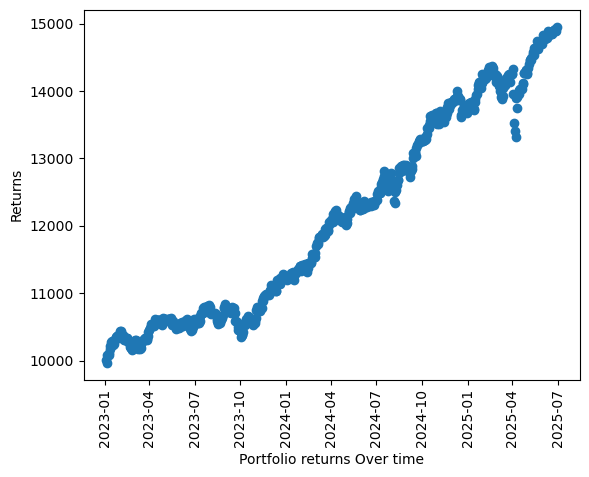

In [180]:
plt.scatter(portfolio_returns_df["Date"], portfolio_returns_df['Portfolio Value'])
plt.xlabel('Portfolio returns Over time')
plt.xticks(rotation=90)
plt.ylabel('Returns')
plt.show()
